In [36]:
'''
/**
* 2/2021
* Pontifícia Universidade Católica de Minas Gerais
* Advisor - Prof. Alexei Machado
* Designed by:
* @author Igor Machado Seixas - 561897
* @version 0.10a
*/
'''

'''
/**
* Libraries:
* Numpy - PIL - sklearn - torch - sklearn
*/
'''

import numpy as np
import os
import random
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.models as models

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from PIL import Image
from PIL import ImageOps

import matplotlib.pyplot as plt

from pathlib import Path

In [37]:
# Configuration.
#root_directory = f'..//Datasets//Colombiam//thyroid-cut'
path = os.getcwd()
root_directory = os.path.dirname(path)+'\Datasets\Colombiam\\thyroid-full-img'
print(root_directory)
train_ratio = .7
validation_ratio = .25
rotation_angle = 90

random_seed = 15
torch.manual_seed(random_seed) # Preavesibility
batch_size = 64
#num_workers = 100

c:\Users\igormseixas\TCC_II\Datasets\Colombiam\thyroid-full-img


In [38]:
# Data preparation.
# transform_train = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), transforms.Grayscale(num_output_channels=1)])
# transform_test = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), transforms.Grayscale(num_output_channels=1)])
# transform_train = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# transform_test = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# transform_train = transforms.Compose([transforms.CenterCrop(300), transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.4,], std=[0.1,])])
# transform_test = transforms.Compose([transforms.CenterCrop(300), transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.4,], std=[0.1,])])
# transform_train = transforms.Compose([transforms.CenterCrop(300), transforms.ToTensor(), transforms.Normalize(mean=[0.4,], std=[0.1,])])
# transform_test = transforms.Compose([transforms.CenterCrop(300), transforms.ToTensor(), transforms.Normalize(mean=[0.4,], std=[0.1,])])
transform_train = transforms.Compose([transforms.CenterCrop(300), transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET), transforms.ToTensor()])
transform_test = transforms.Compose([transforms.CenterCrop(300), transforms.ToTensor()])
#transform_train = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
#transform_test = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [39]:
# Device configuration.
if torch.cuda.is_available(): 
    device = torch.device('cuda')
    print('Running on cuda')
    # Distribute across "2" gpus
    #model = nn.DataParallel(model)
    #print('Running on multiple gpus')
else:
    device = torch.device('cpu')
    print('Running on cpu')

Running on cuda


In [40]:
# Funciton to rotate images.
# Param img_folder - contains the image folder path.
# Param rotation angle - angle which you want to be rotated.
def rotate_augmentation(img_folder, rotation_angle):
    # Iteract in the files directory.
    for dir in os.listdir(img_folder):
        if not "-rotate_augmentation" in dir and not "-mirroring_augmentation" in dir:
            for file in os.listdir(os.path.join(img_folder, dir)):
                image_path = os.path.join(img_folder, dir,  file)
                image = Image.open(image_path)

                # Check if directory exists.
                Exist = os.path.exists(f"{img_folder}{dir}-rotate_augmentation")
                if not Exist:
                    os.mkdir(f"{img_folder}{dir}-rotate_augmentation")

                # Rotate according to rotation_angle and save the image in a new directory.
                angle = int(360/rotation_angle)
                for i in range(1,angle):
                    rotated_image = image.rotate(i*rotation_angle)
                    rotated_image.save(f"{img_folder}{dir}-rotate_augmentation/r_{i}_{file}", quality=96)

# Function to mirror images.
# Param img_folder - contains the image folder path.
def mirroring_augmentation(img_folder):
    # Iteract in the files directory.
    for dir in os.listdir(img_folder):
        if not "-mirroring_augmentation" in dir:
            for file in os.listdir(os.path.join(img_folder, dir)):
                image_path = os.path.join(img_folder, dir,  file)
                image = Image.open(image_path)

                # Check if directory exists.
                Exist = os.path.exists(f"{img_folder}{dir}-mirroring_augmentation")
                if not Exist:
                    os.mkdir(f"{img_folder}{dir}-mirroring_augmentation")
                
                # Mirror and save image in a new directory.
                rotated_image = ImageOps.mirror(image)
                rotated_image.save(f"{img_folder}{dir}-mirroring_augmentation/m_{file}", quality=96)

In [41]:
# Function to augmentate data. Execute roation and mirroring in the images.
# Param img_folder - contains the image folder path.
# Param rotation angle - angle which you want to be rotated.
def data_augmentation(img_folder, rotation_angle):
    rotate_augmentation(img_folder, rotation_angle)
    mirroring_augmentation(img_folder)    

In [42]:
# Function to create a dataset with a set of training and test set and a set of classes.
# Param img_folder - contains the image folder path.
# Param train_size - contains the size of the training set.
# Param...
def load_dataset(img_folder, train_ratio, validation_ratio, transform_train, transform_test, rotation_angle=0, batch_size=64, data_augmentation=False):
    image_data_train=[]
    image_data_val=[]
    image_data_test=[]
    image_class=[]

    file_name_memory = []
    file_name_memory_train = []
    file_name_memory_val = []

    # Create data augmentation if true
    if data_augmentation:
        data_augmentation(img_folder, rotation_angle)

    # Iteract in the files directory.
    for dir in os.listdir(img_folder):
        if dir.startswith('8'): continue
        print(dir)
        file_name_memory = [s for s in os.listdir(os.path.join(img_folder, dir))] # Get all the names.
        file_name_memory = list(zip(*(iter(file_name_memory),) * 1)) # Create group of 1 files.
        # Randonize the names by group.
        random.Random(random_seed).shuffle(file_name_memory)
        # Get train_ratio to put into file_name_memory_train and file_name_memory_test.
        file_name_memory_train = file_name_memory[:int(len(file_name_memory)*train_ratio)] # First n*train_ratio elements.
        file_name_memory_val = file_name_memory_train[:int(len(file_name_memory_train)*validation_ratio)] # First n*validation_ratio elements.
        
        # Flat train list and validation.
        file_name_memory_train = list(itertools.chain(*file_name_memory_train))
        file_name_memory_val = list(itertools.chain(*file_name_memory_val))

        for file in os.listdir(os.path.join(img_folder, dir)):
            image_path = os.path.join(img_folder, dir,  file)
            image = transform_train(Image.open(image_path))
            image = np.array(image)

            # The first train_ratio times append to the image_data_train.
            if file in file_name_memory_train:
                if file in file_name_memory_val:
                    # Append de image data to the validation set.
                    image_data_val.append([image,int(dir[0])]) 
                else:
                    # Append de image data to the training set.
                    image_data_train.append([image,int(dir[0])])                       
            else:
                # Append de image data to an image_data_x array and a image_data_y with the classifiers.
                image_data_test.append([image,int(dir[0])])

        image_class.append(dir)   

    # Defining data training, validation and test sizes.
    train_size = int(train_ratio * len(image_data_train))
    val_size = len(image_data_train) - train_size

    # Get the train_data, val_data and the test_data.
    #train_data, val_data = random_split(image_data_train, [train_size, val_size], generator=torch.Generator().manual_seed(random_seed))

    # Transform into DataLoader 
    train_dl = DataLoader(image_data_train, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(image_data_val, batch_size=batch_size, shuffle=False)
    test_dl = DataLoader(image_data_test, batch_size=batch_size, shuffle=False)
    classes = np.array(image_class)

    return train_dl, val_dl, test_dl, classes

In [43]:
# Get train and test data.
train_dl, val_dl, test_dl, classes = load_dataset(root_directory, train_ratio, validation_ratio, transform_train, transform_test, batch_size=batch_size)
# Print size of training, validation and test sets.
print("Training size: ", len(train_dl.dataset))
print("Validation size: ", len(val_dl.dataset))
print("Test size: ", len(test_dl.dataset))
print("Total size: ", len(train_dl.dataset)+len(val_dl.dataset)+len(test_dl.dataset))

1
2
3
4-4a
5-4b
6-4c
7-5
Training size:  185
Validation size:  57
Test size:  107
Total size:  349


Feature batch shape: torch.Size([64, 3, 300, 300])
Labels batch shape: torch.Size([64])


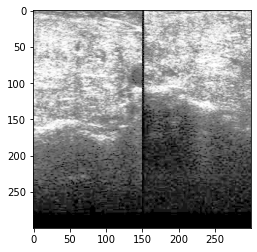

Label: 5


In [44]:
# Display image and label.
image_to_display_number = 0
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[image_to_display_number].squeeze()
label = train_labels[image_to_display_number]
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)
plt.imshow(img, cmap="gray", vmin=0, vmax=1)
plt.show()
print(f"Label: {label}")

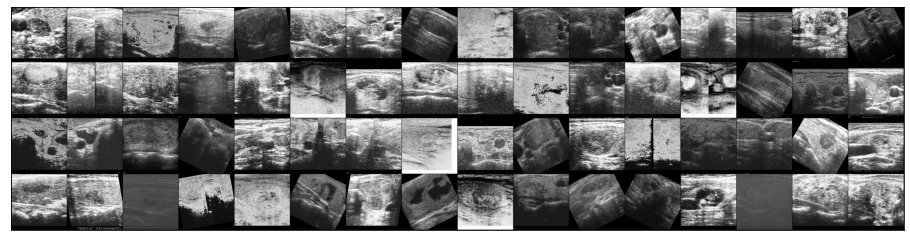

In [45]:
# Function to show the batch of the Dataset.
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [46]:
class RNet(nn.Module):
    def __init__(self):
        super(RNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 56, kernel_size= (13,13), stride=4, padding=(0,0))
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=56, out_channels=112, kernel_size= (7,7), stride= 1, padding=(0,0))
        self.conv3 = nn.Conv2d(in_channels=112, out_channels=224, kernel_size= (5,5), stride= 1, padding=(2,2))
        self.conv4 = nn.Conv2d(in_channels=224, out_channels=336, kernel_size= (3,3), stride= 1, padding=(1,1))
        self.conv5 = nn.Conv2d(in_channels=336, out_channels=336, kernel_size= (3,3), stride= 1, padding=(1,1))
        self.conv6 = nn.Conv2d(in_channels=336, out_channels=224, kernel_size= (3,3), stride= 1, padding=(1,1))
        self.fc1  = nn.Linear(in_features= 224, out_features= 448)
        self.fc2  = nn.Linear(in_features= 448, out_features=224)
        self.fc3  = nn.Linear(in_features= 224, out_features=112)
        self.fc4  = nn.Linear(in_features= 112, out_features=10)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)
        x = F.dropout2d(x, 0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout2d(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [47]:
# Defining the model.
#model = RNet()
model = models.alexnet(pretrained=True)
#model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#model = models.densenet161()
#model = models.densenet161(pretrained=True)
#modelOutputFeats = model.classifier.in_features
#model.classifier = nn.Linear(modelOutputFeats, 9)
model = model.to(device=device)

# Loss and optimizer.
learning_rate = 1e-4 #It was 0.07
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate) # Adam
# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) TEST AFTERRRR
    
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [48]:
# CNN Configuration.
epochs = 200

In [49]:
# Training section.
for epoch in range(epochs):
    loss_ep = 0
    loss_ep_val = 0
    
    for batch_idx, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")
    
    # Check the loss if is lower than 0.001 stops the training process.
    # Overfit control.
    if (loss_ep/len(train_dl)) <= 0.001:
        break

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = model(data)
            loss_val = criterion(scores,targets)
            loss_ep_val += loss_val.item()
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(f"Loss validation in epoch {epoch} :::: {loss_ep_val/len(val_dl)}")
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )

Loss in epoch 0 :::: 4.844366947809855
Loss validation in epoch 0 :::: 3.024665355682373
Got 16 / 57 with accuracy 28.07
Loss in epoch 1 :::: 2.9598100980122886
Loss validation in epoch 1 :::: 2.3975300788879395
Got 14 / 57 with accuracy 24.56
Loss in epoch 2 :::: 2.196945309638977
Loss validation in epoch 2 :::: 2.0227339267730713
Got 7 / 57 with accuracy 12.28
Loss in epoch 3 :::: 1.9839187860488892
Loss validation in epoch 3 :::: 1.6944645643234253
Got 16 / 57 with accuracy 28.07
Loss in epoch 4 :::: 1.7692046165466309
Loss validation in epoch 4 :::: 1.8027805089950562
Got 15 / 57 with accuracy 26.32
Loss in epoch 5 :::: 1.6990814606348674
Loss validation in epoch 5 :::: 1.7306804656982422
Got 14 / 57 with accuracy 24.56
Loss in epoch 6 :::: 1.659922480583191
Loss validation in epoch 6 :::: 1.7498592138290405
Got 17 / 57 with accuracy 29.82
Loss in epoch 7 :::: 1.606863300005595
Loss validation in epoch 7 :::: 1.8001130819320679
Got 17 / 57 with accuracy 29.82
Loss in epoch 8 :::: 1

In [15]:
# Check accuraccy of the training set.
# Function to give accuracy of a given data set. It will returns the predict and output to
# check using other metrics.
def check_acc(dataloader):
    # Get the data.
    num_correct = 0
    num_samples = 0
    predict = []
    target = []
    for batch_idx, (data,targets) in enumerate(dataloader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        ## Forward Pass
        scores = model(data)
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)    

        predict = predict + predictions.to(device="cpu").numpy().tolist()
        target = target + targets.to(device="cpu").numpy().tolist()
    print(
        f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
    )

    return target, predict



In [24]:
train_output, train_predict = check_acc(train_dl)
print('\nResults on the training set:')
print(classification_report(train_output, train_predict))

Got 185 / 185 with accuracy 100.00

Results on the training set:
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        42
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00        24

    accuracy                           1.00       185
   macro avg       1.00      1.00      1.00       185
weighted avg       1.00      1.00      1.00       185



In [25]:
val_output, val_predict = check_acc(val_dl)
print('\nResults on the validating set:')
print(classification_report(val_output, val_predict))

Got 15 / 57 with accuracy 26.32

Results on the validating set:
              precision    recall  f1-score   support

           2       0.33      0.29      0.31         7
           3       0.50      0.33      0.40         3
           4       0.13      0.12      0.13        16
           5       0.25      0.15      0.19        13
           6       0.25      0.45      0.32        11
           7       0.50      0.43      0.46         7

    accuracy                           0.26        57
   macro avg       0.33      0.30      0.30        57
weighted avg       0.27      0.26      0.26        57



In [26]:
test_output, test_predict = check_acc(test_dl)
print('\nResults on the test set:')
print(classification_report(test_output, test_predict))
print('\nResults as Confusion Matrix:')
print(confusion_matrix(test_output, test_predict))

Got 31 / 107 with accuracy 28.97

Results on the test set:
              precision    recall  f1-score   support

           2       0.08      0.08      0.08        13
           3       0.20      0.17      0.18         6
           4       0.37      0.52      0.43        29
           5       0.25      0.17      0.20        24
           6       0.32      0.33      0.33        21
           7       0.27      0.21      0.24        14

    accuracy                           0.29       107
   macro avg       0.25      0.25      0.24       107
weighted avg       0.27      0.29      0.28       107


Results as Confusion Matrix:
[[ 1  2  4  4  2  0]
 [ 2  1  2  0  1  0]
 [ 2  1 15  3  3  5]
 [ 1  0 11  4  6  2]
 [ 2  1  6  4  7  1]
 [ 4  0  3  1  3  3]]


In [9]:
torch.save(model.state_dict(), f'my_model/my_model_xxx')

NameError: name 'model' is not defined

In [10]:
#model = RNet()
device = torch.device('cuda')
model = models.densenet161()
model = model.to(device=device)
model.load_state_dict(torch.load(f'my_model\my_model_xxx'))
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [19]:
# Transfer learning process. Set the parameters to non-trainable.
for param in model.parameters():
    param.requires_grad = False

# Add the classification of 8 classes to the pre-trained network.
modelOutputFeats = model.classifier.in_features
model.classifier = nn.Linear(modelOutputFeats, 9)
model = model.to(device=device)
model.classifier

Linear(in_features=2208, out_features=9, bias=True)

In [20]:
# Redefining learning.
# Loss and optimizer.
learning_rate = 1e-4 #It was 0.07
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate) # Adam

In [21]:
epochs = 10

In [22]:
# Retrain the model
# Training section.
for epoch in range(epochs):
    loss_ep = 0
    loss_ep_val = 0
    
    for batch_idx, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")
    
    # Check the loss if is lower than 0.001 stops the training process.
    # Overfit control.
    if (loss_ep/len(train_dl)) <= 0.001:
        break

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = model(data)
            loss_val = criterion(scores,targets)
            loss_ep_val += loss_val.item()
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(f"Loss validation in epoch {epoch} :::: {loss_ep_val/len(val_dl)}")
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )

Loss in epoch 0 :::: 0.5780619517806543
Loss validation in epoch 0 :::: 2.3102102239926654
Got 180 / 600 with accuracy 30.00
Loss in epoch 1 :::: 0.10539617004194653
Loss validation in epoch 1 :::: 2.5521505681673684
Got 182 / 600 with accuracy 30.33
Loss in epoch 2 :::: 0.05385138302383174
Loss validation in epoch 2 :::: 2.7231335894266766
Got 183 / 600 with accuracy 30.50
Loss in epoch 3 :::: 0.041487217878915336
Loss validation in epoch 3 :::: 2.8811387252807616
Got 181 / 600 with accuracy 30.17
Loss in epoch 4 :::: 0.0340069173330284
Loss validation in epoch 4 :::: 3.075357133547465
Got 169 / 600 with accuracy 28.17
Loss in epoch 5 :::: 0.025635860809386825
Loss validation in epoch 5 :::: 3.153798108100891
Got 179 / 600 with accuracy 29.83
Loss in epoch 6 :::: 0.01995745983187962
Loss validation in epoch 6 :::: 3.2376830124855043
Got 176 / 600 with accuracy 29.33
Loss in epoch 7 :::: 0.020623433887799567
Loss validation in epoch 7 :::: 3.3391213945547737
Got 181 / 600 with accuracy

In [25]:
del model
torch.cuda.empty_cache()